In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
import random
import seaborn as sns
#import matplotlib as mpl
from sklearn.model_selection import train_test_split

tfk = tf.keras
tfkl = tf.keras.layers

In [2]:
# Random seed for reproducibility
seed = 1

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
# Utility function to create folders and callbacks for training
from datetime import datetime

exp_dir = ''

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%Y-%m-%d_%H:%M')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tfk.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp'),
                                                save_weights_only=False,
                                                save_best_only=False)
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                               profile_batch=0,
                                               histogram_freq=1)
  callbacks.append(tb_callback)

In [4]:
#!unzip ANN_HW1.zip
#import zipfile
#with zipfile.ZipFile("dataset.zip", 'r') as z:
#    z.extractall()

In [5]:
# Set the path to the dataset 

dataset_dir = '../input/homework1/training/'

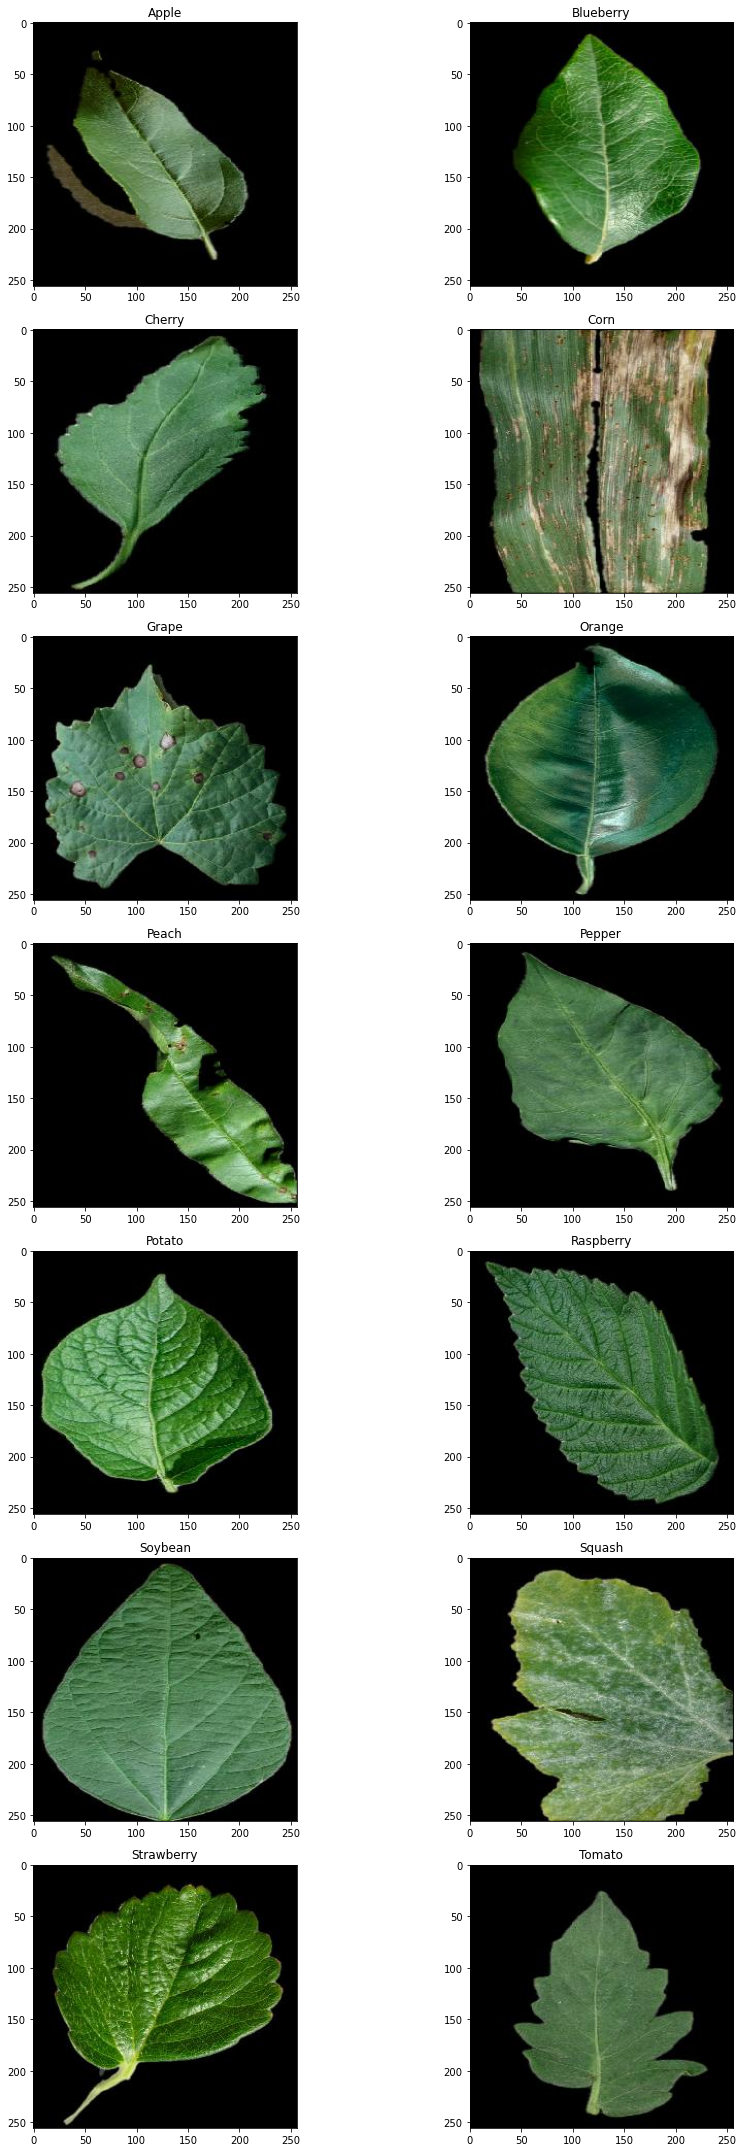

In [6]:
# Plot example images from dataset
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
    if i < len(labels):
        class_imgs = next(os.walk('{}/{}/'.format(dataset_dir, labels[i])))[2]
        class_img = class_imgs[0]
        img = Image.open('{}/{}/{}'.format(dataset_dir, labels[i], class_img))
        ax = axes[i//num_col, i%num_col]
        ax.imshow(np.array(img))
        ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [7]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training, validation, and test sets
data_gen = ImageDataGenerator(rotation_range=30,
                              height_shift_range=50,
                              width_shift_range=50,
                              zoom_range=0.3,
                              horizontal_flip=True,
                              vertical_flip=True, 
                              fill_mode='reflect',
                              rescale=1/255, 
                              validation_split=0.2)    


# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method

train_dataset = data_gen.flow_from_directory(directory=dataset_dir,
                                                target_size=(256,256),
                                                color_mode='rgb',
                                                classes=None,
                                                batch_size=128,
                                                shuffle=True,
                                                subset="training",
                                                class_mode='categorical',
                                                seed=seed)

validation_dataset = data_gen.flow_from_directory(directory=dataset_dir,
                                                target_size=(256,256),
                                                color_mode='rgb',
                                                classes=None,
                                                batch_size=128,
                                                shuffle=True,
                                                subset="validation",
                                                class_mode='categorical',
                                                seed=seed)

Found 14189 images belonging to 14 classes.
Found 3539 images belonging to 14 classes.


In [8]:
#Normalization

files_per_class = []
for folder in os.listdir(dataset_dir):
    if not os.path.isfile(folder):
            files_per_class.append(len(os.listdir(dataset_dir + '/' + folder)))
total_files = sum(files_per_class)
class_weights = {}
for i in range(len(files_per_class)):
    class_weights[i] = 1 - (float(files_per_class[i]) / total_files)
print (class_weights)

{0: 0.944268953068592, 1: 0.9736574909747292, 2: 0.9671141696750902, 3: 0.9319720216606499, 4: 0.9177572202166064, 5: 0.9013989169675091, 6: 0.944889440433213, 7: 0.9568479241877257, 8: 0.9596119133574007, 9: 0.9851083032490975, 10: 0.9088447653429603, 11: 0.9676218411552346, 12: 0.9620374548736462, 13: 0.6788695848375451}


In [9]:
input_shape = (256, 256, 3)
epochs = 150
model_name = '3layers_earlystop_aug'

In [10]:
def build_model(input_shape):
#create model

    model = tfk.Sequential()
    model.add(tfkl.Conv2D(16,kernel_size=(5, 5),activation='relu',padding='same', kernel_initializer=tfk.initializers.GlorotUniform(seed), input_shape=input_shape))
    model.add(tfkl.MaxPooling2D((2, 2),strides=(2,2)))

    model.add(tfkl.Conv2D(32,(3, 3), activation='relu',padding='same', kernel_initializer=tfk.initializers.GlorotUniform(seed)))
    model.add(tfkl.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    
    model.add(tfkl.Conv2D(64,(3, 3), activation='relu',padding='same', kernel_initializer=tfk.initializers.GlorotUniform(seed)))
    model.add(tfkl.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    
    model.add(tfkl.Flatten())
  
    model.add(tfkl.Dense(14, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(1e-5)))
    
    # Compile the model
    learning_rate = 0.001
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate), metrics='accuracy')

    # Return the model
    return model

2021-11-19 10:02:51.185821: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-19 10:02:51.191811: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0

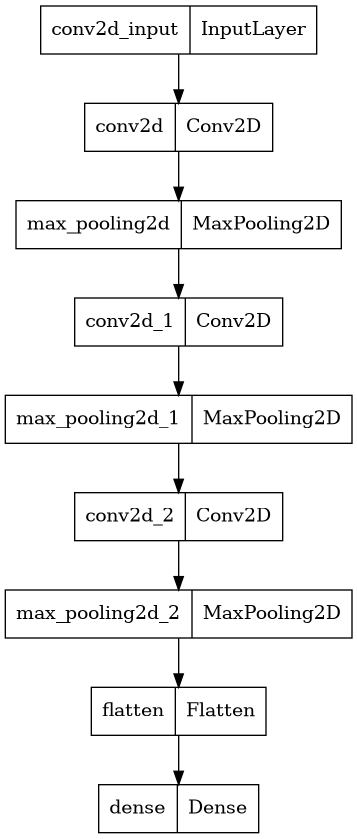

In [11]:
model = build_model(input_shape)
model.summary()
tfk.utils.plot_model(model)

In [12]:
patience = 10
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=patience, restore_best_weights=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      1216      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 64)      

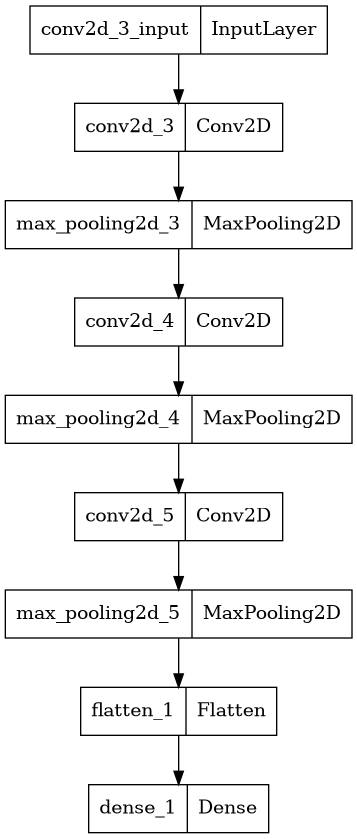

In [13]:
earlystopping_model = build_model(input_shape)
earlystopping_model.summary()
tfk.utils.plot_model(earlystopping_model)

In [14]:
callbacks = create_folders_and_callbacks(model_name=model_name)

# Train the model
history = earlystopping_model.fit(
    x = train_dataset,
    epochs = epochs,
    validation_data = validation_dataset,
    class_weight = class_weights,
    callbacks = [early_stopping]
).history

Epoch 1/60
 18/111 [===>..........................] - ETA: 7:55 - loss: 2.0266 - accuracy: 0.3225

In [ ]:
# Save the model
model.save(os.path.join(exp_dir, model_name))

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()